# 15-minute-city analysis in Graz, Austria

### GIS analysis techniques 2: Final project

Kornelia Birkle, Vita Duit, Timon Wutte, Florian Zaar

A reproducible workflow to find served and underserved areas in a 15-minute-city frame and suggestions for new facilities to expand the 15-minute-city.

### Content:

##### Data integration:
- city boundaries of Graz
- street network of Graz and surrounding area within 1000m
- POIs in Graz and surrounding area withing 1000m: 
  public transport stations, supermarkets, green spaces, pharmacies, doctors
- population of Graz for the year 2020 (100x100m grid)
- buildings of Graz
- residential areas of Graz
##### Data management:
- Data cleaning
- Building POI dataset with consistent columns, categorised by type of POI

##### Network analysis:
- Routing from all POIs to network nodes with cutoff 1000m (15 minutes on foot)
- Find nodes with all 5 POI types ("served areas")
- Accessibility statistics of population and area within served areas

##### Scenario: Expand 15-minute-city by adding facilities
- Find nodes with 4 of 5 POI types
- Cluster these nodes with DBSCAN
- Assign new facilities in centroids of these clusters
- Recalculate accessibility statistics

#### Data sources:
- City Boundaries:
OpenStreetMap contributors (2025). OpenStreetMap database (city & District Boundaries). Retrieved December 22, 2025, from https://www.openstreetmap.org
- Street Network:
OpenStreetMap contributors (2025). OpenStreetMap database (Street Network). Retrieved December 23, 2025, from https://www.openstreetmap.org
- POIs:
OpenStreetMap contributors. (2025). OpenStreetMap database (POI). Retrieved December 25, 2025, from https://www.openstreetmap.org
- Population 2020 (100m grid):
Pesaresi, M., Schiavina, M., Politis, P., Freire, S., Krasnodębska, K., Uhl, J. H., Carioli, A., Corbane, C., Dijkstra, L., Florio, P., Friedrich, H. K., Gao, J., Leyk, S., Lu, L., Maffenini, L., Mari-Rivero, I., Melchiorri, M., Syrris, V., Van Den Hoek, J., & Kemper, T. (2023). GHS-POP R2023A — GHS population grid multitemporal (1975–2030). Dataset: GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C20. European Commission, Joint Research Centre. https://doi.org/10.2905/2FF68A52-5B5B-4A22-8F40-C41DA8332CFE. Available under: https://human-settlement.emergency.copernicus.eu/download.php?ds=pop
- Buildings:
OpenStreetMap contributors (2025). OpenStreetMap database (Buildings). Retrieved December 26, 2025, from https://www.openstreetmap.org
- Residential Areas:
OpenStreetMap contributors (2025). OpenStreetMap database (Residential). Retrieved December 26, 2025, from https://www.openstreetmap.org

## Imports and pip installs

In [1]:
#!pip install osmnx rasterio

In [2]:
#!pip install pyarrow

In [3]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
import numpy as np
from pathlib import Path
import networkx as nx
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon, box
from collections import defaultdict
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import copy
import pyarrow
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

#### Definitions of paths and project variables

In [4]:
BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"
DATA_DIR.mkdir(exist_ok=True)
RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True)

POP_RAW_PATH = BASE_DIR / "GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif" # adjust this path after downloading
POP_GRAZ_PATH = "preprocessed/graz_population.tif"
GRAPH_PATH = DATA_DIR / "graz_street_network_buffer1km.graphml"
EDGE_PATH = DATA_DIR / "graz_street_network_edges.parquet"
NODE_PATH = DATA_DIR / "graz_street_network_nodes.parquet"
POI_PATH = DATA_DIR / "graz_pois.parquet"
GREEN_SPACES_PATH = DATA_DIR / "graz_green_spaces_raw.parquet"
ACCESS_POINTS_PATH = DATA_DIR / "graz_green_access_points.parquet"
RESIDENTIAL_PATH = DATA_DIR / "graz_residential_areas.parquet"
BUILDINGS_PATH = DATA_DIR / "graz_buildings.parquet"
POI_ALL_PATH = DATA_DIR / "graz_pois_all.parquet"
POI_ALL_POINTS_PATH = DATA_DIR / "graz_pois_all_points.parquet"



project_crs = 31256  # MGI / Austria GK East

## Data integration

For the 15-minute-city analysis, open data sources are used. Street network, residential areas and POIs (facilities) are taken from OSM, the population grid (100m x 100m) from Global Human Settlement Layer.

#### Load city boundary of Graz

In [5]:
# define place name
place_name:str = "Graz, Austria"

# get the boundary polygon of Graz
gdf_graz = ox.geocode_to_gdf(place_name)

# change CRS to EPSG: 31256
gdf_graz = gdf_graz.to_crs(epsg=project_crs)

#### Load district boundaries of Graz

In [6]:
# get districts of Graz
gdf_districts = ox.features_from_place(place_name, tags={'admin_level': '9'})

# filter to get only polygons and reproject
gdf_districts = gdf_districts[gdf_districts.geometry.type.isin(['Polygon', 'MultiPolygon'])]
gdf_districts = gdf_districts.to_crs(epsg=project_crs)

# drop all columns except 'name' and 'geometry'
gdf_districts = gdf_districts[['name', 'geometry']]

#### Load street network of Graz and 1000m beyond

In [7]:
# buffer (1000m) boundary of Graz to include streets and POIs just outside the city limits
buffered_poly_31256 = gdf_graz.geometry.iloc[0].buffer(1000)

# reproject buffer for osmnx (WGS84)
buffered_poly_wgs84 = (
    gpd.GeoSeries([buffered_poly_31256], crs=f"EPSG:{project_crs}")
    .to_crs("EPSG:4326")
    .iloc[0]
)

# load pre-saved street network and nodes/edges GeoDataFrames if they exist, otherwise create and save them
try:
    edges = gpd.read_parquet(EDGE_PATH)
    nodes = gpd.read_parquet(NODE_PATH)
    network_graz = ox.load_graphml(GRAPH_PATH)
except:
    # load street network in buffered polygon, network_type = 'walk'
    
    G = ox.graph_from_polygon(
        buffered_poly_wgs84,
        network_type="walk",
        simplify=True
    )

    # reproject to project crs
    G = ox.project_graph(G, to_crs=f"EPSG:{project_crs}")
    ox.save_graphml(G, filepath=GRAPH_PATH)
    network_graz = ox.load_graphml(GRAPH_PATH)

    # convert street network graphs into two GeoDataFrames
    nodes_raw, edges_raw = ox.graph_to_gdfs(G, nodes=True, edges=True)

    # remove list columns
    def drop_list_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
        list_cols = [
            c for c in gdf.columns
            if c != "geometry" and gdf[c].apply(lambda x: isinstance(x, list)).any()
        ]
        return gdf.drop(columns=list_cols)

    edges_clean = drop_list_columns(edges_raw)
    nodes_clean = drop_list_columns(nodes_raw)

    # save as GeoParquet
    edges_clean.to_parquet(EDGE_PATH, index=False)
    nodes_clean.to_parquet(NODE_PATH, index=False)
    edges = gpd.read_parquet(EDGE_PATH)
    nodes = gpd.read_parquet(NODE_PATH)

Quick overview map: Plot nodes, edges and boundary of Graz

<Axes: >

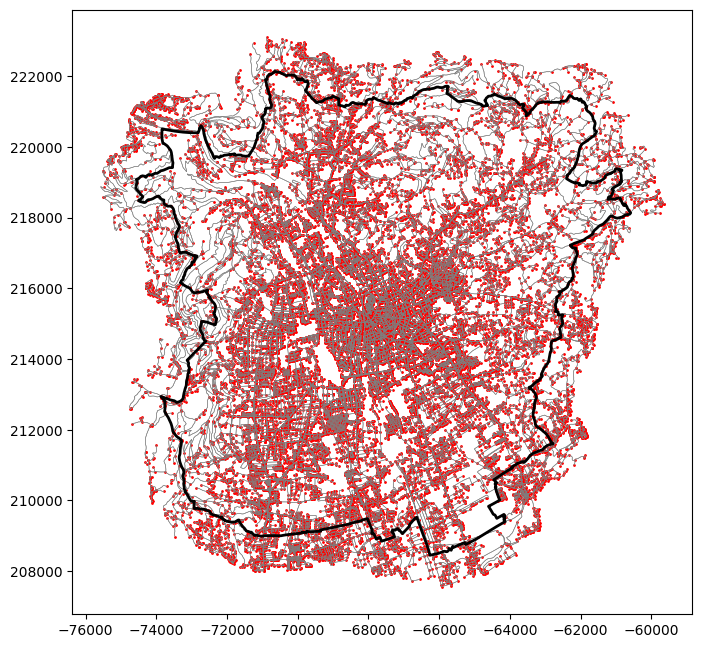

In [8]:
ax = edges.plot(figsize=(8, 8), linewidth=0.4, color="grey")
nodes.plot(ax=ax, markersize=1, color="red")

gdf_graz.boundary.plot(ax=ax, edgecolor="black", linewidth=2)

##### Load residential areas

In [9]:
# get residential areas of Graz
gdf_residential_raw = ox.features_from_place(place_name, tags={"landuse": "residential"})
gdf_residential = gdf_residential_raw.to_crs(epsg=31256)

gdf_residential = gdf_residential.dissolve()

gdf_residential = gpd.overlay(gdf_residential, gdf_graz, how='intersection')

# Save residential areas as GeoParquet
gdf_residential.to_parquet(RESIDENTIAL_PATH, index=False) 
gdf_residential = gpd.read_parquet(RESIDENTIAL_PATH)
gdf_residential = gdf_residential.to_crs(epsg=project_crs)

c:\Users\vitad\studium\GST_S3\GAT2\venv-gst200b311\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 249 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


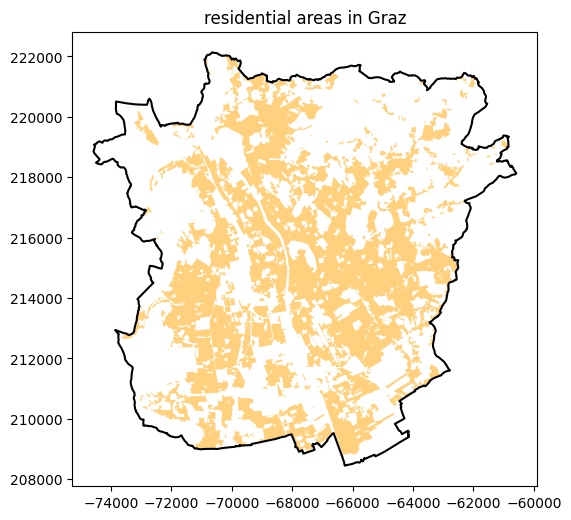

In [10]:
ax = gdf_graz.boundary.plot(edgecolor="black", figsize=(6, 6))

gdf_residential.plot(
    ax=ax,
    color="orange",
    alpha=0.5
)

plt.title("residential areas in Graz")
plt.show()

##### Load population grid

In [11]:
# Check if the preprocessed population grid for Graz exists, otherwise create it
try: 
    with rasterio.open(POP_GRAZ_PATH) as dataset:
        graz_pop = dataset.read(1)
except:
    # open grid data set (population grid)
    src = rasterio.open(POP_RAW_PATH)
    #print(src.crs)

    # project Graz border into grid CRS (ESRI: 54009)
    graz_geom = gdf_graz.to_crs(src.crs).geometry.iloc[0]

    # mask grid with Graz geometry (pixels outside Graz are removed)
    out_img, out_transform = mask(
        dataset=src,
        shapes=[graz_geom],
        crop=True
    )
    # copy metadata from the original grid and adjust metadata to the cropped grid
    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_img.shape[1],
        "width":  out_img.shape[2],
        "transform": out_transform
    })
    # write and save a new grid
    with rasterio.open(POP_GRAZ_PATH, "w", **out_meta) as dst:
        dst.write(out_img)
    
    with rasterio.open(POP_GRAZ_PATH) as dataset:
        graz_pop = dataset.read(1)

Visualization for quick overview

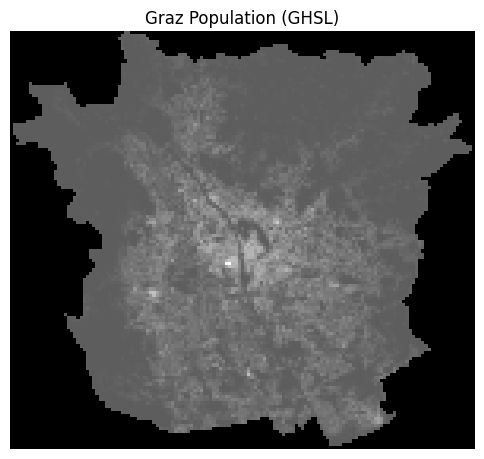

In [12]:
plt.figure(figsize=(6, 6))
plt.imshow(graz_pop, cmap="gray")
plt.title("Graz Population (GHSL)")
plt.axis("off")
plt.show()

#### Load POIs in Graz and immediate surrounding area


POIs considered necessary in daily life (should be within 15-minute walking distance): 
- public transport stations (bus and tram stops)
- supermarkets
- green spaces
- pharmacies
- doctors

##### Define POI tags for OSM query

In [13]:
tags = {
    # public transport stations & stops
    "highway": ["platform", "bus_stop"],
    "public_transport": ["platform", "stop_position"],
    "railway": ["tram_stop"],

    # supermarkets
    "shop": ["supermarket", "chemist"],

    # pharmacies & doctors
    "amenity": ["doctors", "pharmacy"],
}

# Green spaces are defined separately for preprocessing
tags_green_spaces = {
    # green spaces
    "leisure": ["park", "garden", "recreation_ground"],
    "landuse": ["forest", "recreation_ground", "cemetery"],
    "natural": ["wood"],
    "amenity": ["park", "playground", "graveyard"],
}

##### Load public transport stations, supermarkets, pharmacies and doctors from OSM

In [14]:
pois = ox.features_from_polygon(buffered_poly_wgs84, tags=tags) # osmnx sends a request to the Overpass API
pois = pois.to_crs(f"EPSG:{project_crs}")
pois = pois.to_parquet(POI_PATH, index=False)
pois = gpd.read_parquet(POI_PATH)

##### Load green spaces

In [15]:
# Query raw green spaces once
green_spaces_raw = ox.features_from_polygon(buffered_poly_wgs84, tags=tags_green_spaces)
green_spaces_raw = green_spaces_raw.to_crs(f"EPSG:{project_crs}")

# Save as GeoParquet
green_spaces_raw.to_parquet(GREEN_SPACES_PATH, index=False)
green_spaces = gpd.read_parquet(GREEN_SPACES_PATH)

## Data management

The data for the POIs has to be prepared for the 15-minute-city analysis, making sure there are only point geometries in the dataset and categorizing the POIs into POI types. They also have to be snapped to nearest nodes in the street network for the routing in the network analysis.

##### Non-public green spaces and green spaces within 50 meters of major roads are excluded

In [16]:
# Drop private gardens without name
green_spaces = green_spaces[~((green_spaces["leisure"] == "garden") & (green_spaces["name"].isna()))]

# Exclude public green spaces that are marked as 'no' or 'private' access
green_spaces = green_spaces[green_spaces['access'].isna() | green_spaces['access'].isin(['yes', 'permissive'])]

# Exclude green spaces smaller than 1 ha
green_spaces = green_spaces[green_spaces.geometry.area >= 10000]

# Exclude green spaces within 50m of major roads (highways and trunks)
# Download Highways and trunks in Graz from osmnx
highways = ox.features_from_place(
    place_name,
    tags={"highway": ["motorway", "trunk"]}
)
highways = highways.to_crs(epsg=project_crs)
highways = highways[highways['tunnel'] != 'yes']

#create buffer of 50 meters around highways
highway_buffer = highways.buffer(50)
green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]

# Dissolve green spaces
green_spaces = green_spaces.dissolve(as_index=False)

C:\Users\vitad\AppData\Local\Temp\ipykernel_37060\1214611720.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]


##### Calculate access points to green spaces

Since green spaces are usually polygon geometry, they are intersected with the edges in the network to calculate access points (point geometry)

In [17]:
# Extract boundaries of parks as LineStrings
park_boundaries = green_spaces.unary_union.boundary  # Get the actual geometry

# Create a list to store access points
access_points_list = []

# Iterate through each edge and find intersections with park boundaries
for idx, edge in edges.iterrows():
    intersection = edge.geometry.intersection(park_boundaries)
    
    if not intersection.is_empty:
        if intersection.geom_type == 'Point':
            access_points_list.append(intersection)
        elif intersection.geom_type == 'MultiPoint':
            access_points_list.extend(list(intersection.geoms))
        elif intersection.geom_type == 'LineString':
            access_points_list.extend([Point(intersection.coords[0]), Point(intersection.coords[-1])
    ])

# Create GeoDataFrame of access points
access_points = gpd.GeoDataFrame(
    geometry=access_points_list,
    crs=edges.crs
)

# Remove duplicates
access_points = access_points.drop_duplicates(subset=['geometry'])

print(f"Found {len(access_points)} access points")

C:\Users\vitad\AppData\Local\Temp\ipykernel_37060\1210124553.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  park_boundaries = green_spaces.unary_union.boundary  # Get the actual geometry


Found 2611 access points


In [18]:
# Save access points as GeoParquet
access_points.to_parquet(ACCESS_POINTS_PATH, index=False)
access_points = gpd.read_parquet(ACCESS_POINTS_PATH)

##### Put together all POIs into one dataset with consistent columns

For the 15-minute analysis, the POIs should all be in one dataset, distinguished by their analysis_type (public transport, supermarket, green space, pharmacy, doctor).

In [19]:
# initialize columns
pois["poi_group"] = pd.Series(index=pois.index, dtype="string")
pois["poi_subtype"] = pd.Series(index=pois.index, dtype="string")
pois["analysis_type"] = pd.Series(index=pois.index, dtype="string") # For 15-minute analysis


# TRANSPORT
# Filter for POI group 'transport'
transport_mask = (
    pois["highway"].isin(["platform", "bus_stop"])
    | pois["public_transport"].isin(["platform", "stop_position"])
    | pois["railway"].isin(["tram_stop"])
)
pois.loc[transport_mask, "poi_group"] = "transport"

# Fill in tags as subtype
transport_tags = (
    pois.loc[transport_mask, ["highway", "public_transport", "railway"]]
    .astype("string")
    .replace("nan", pd.NA)
    .bfill(axis=1)
    .iloc[:, 0]
)
pois.loc[transport_mask, "poi_subtype"] = transport_tags
pois.loc[transport_mask, "analysis_type"] = "public_transport"


# SHOP
shop_mask = pois["shop"].isin(["supermarket", "chemist"])
pois.loc[shop_mask, "poi_group"] = "shop"
pois.loc[shop_mask, "poi_subtype"] = pois.loc[shop_mask, "shop"]
pois.loc[shop_mask, "analysis_type"] = "shop"


# MEDICAL
medical_values = ["doctors", "pharmacy"]
med_mask = pois["amenity"].isin(medical_values)
pois.loc[med_mask, "poi_group"] = "medical"
pois.loc[med_mask, "poi_subtype"] = pois.loc[med_mask, "amenity"]

# distinguish doctor vs pharmacy for analysis_type
pois.loc[med_mask & (pois["amenity"] == "doctors"), "analysis_type"] = "doctor"
pois.loc[med_mask & (pois["amenity"] == "pharmacy"), "analysis_type"] = "pharmacy"


In [20]:
# Add green spaces access points to POIs
access_points["poi_group"] = "green_space"
access_points["poi_subtype"] = "access_point"
access_points["analysis_type"] = "green_space"

In [21]:
# Save all POIs including green access points into a single GeoParquet

# Make sure both in same CRS
access_points = access_points.to_crs(pois.crs)

# Ensure both have the same columns
all_cols = sorted(set(pois.columns) | set(access_points.columns))

pois_all = pd.concat(
    [
        pois.reindex(columns=all_cols),
        access_points.reindex(columns=all_cols),
    ],
    ignore_index=True,
)

pois_all.to_parquet(POI_ALL_PATH, index=False)
pois_all = gpd.read_parquet(POI_ALL_PATH)

In [22]:
# Drop redundant columns
pois_all = pois_all[['geometry', 'poi_group', 'poi_subtype', 'analysis_type']]

##### Snap all POIs to nearest nodes for routing

Before snapping the POIs to their nearest nodes, it has to be made sure that there are only point geometries in the dataset.

In [23]:
pois_all_points = pois_all.copy()

# Convert LineString and Polygon/MultiPolygon to representative points
mask_non_point = pois_all_points.geometry.geom_type.isin(["LineString", "Polygon", "MultiPolygon"])

# record source of geometry
pois_all_points["geom_source"] = "original_point"
pois_all_points.loc[mask_non_point, "geom_source"] = "representative_point"

# representative_point() is safer than centroid; guaranteed inside polygon
pois_all_points.loc[mask_non_point, "geometry"] = (
    pois_all_points.loc[mask_non_point, "geometry"].representative_point()
)

# Save to Geo Parquet
pois_all_points.to_parquet(POI_ALL_POINTS_PATH, index=False)
pois_all_points = gpd.read_parquet(POI_ALL_POINTS_PATH)

In [24]:
pois_all_points = pois_all_points.to_crs(epsg=project_crs)

# Coordinates of POIs
X = pois_all_points.geometry.x  # x/longitude or projected x
Y = pois_all_points.geometry.y  # y/latitude or projected y
# Nearest node for each POI
nearest_nodes = ox.distance.nearest_nodes(network_graz, X, Y)
pois_all_points["nearest_node"] = nearest_nodes

##### Quick overview map: Plot POIs per tag and boundary of Graz

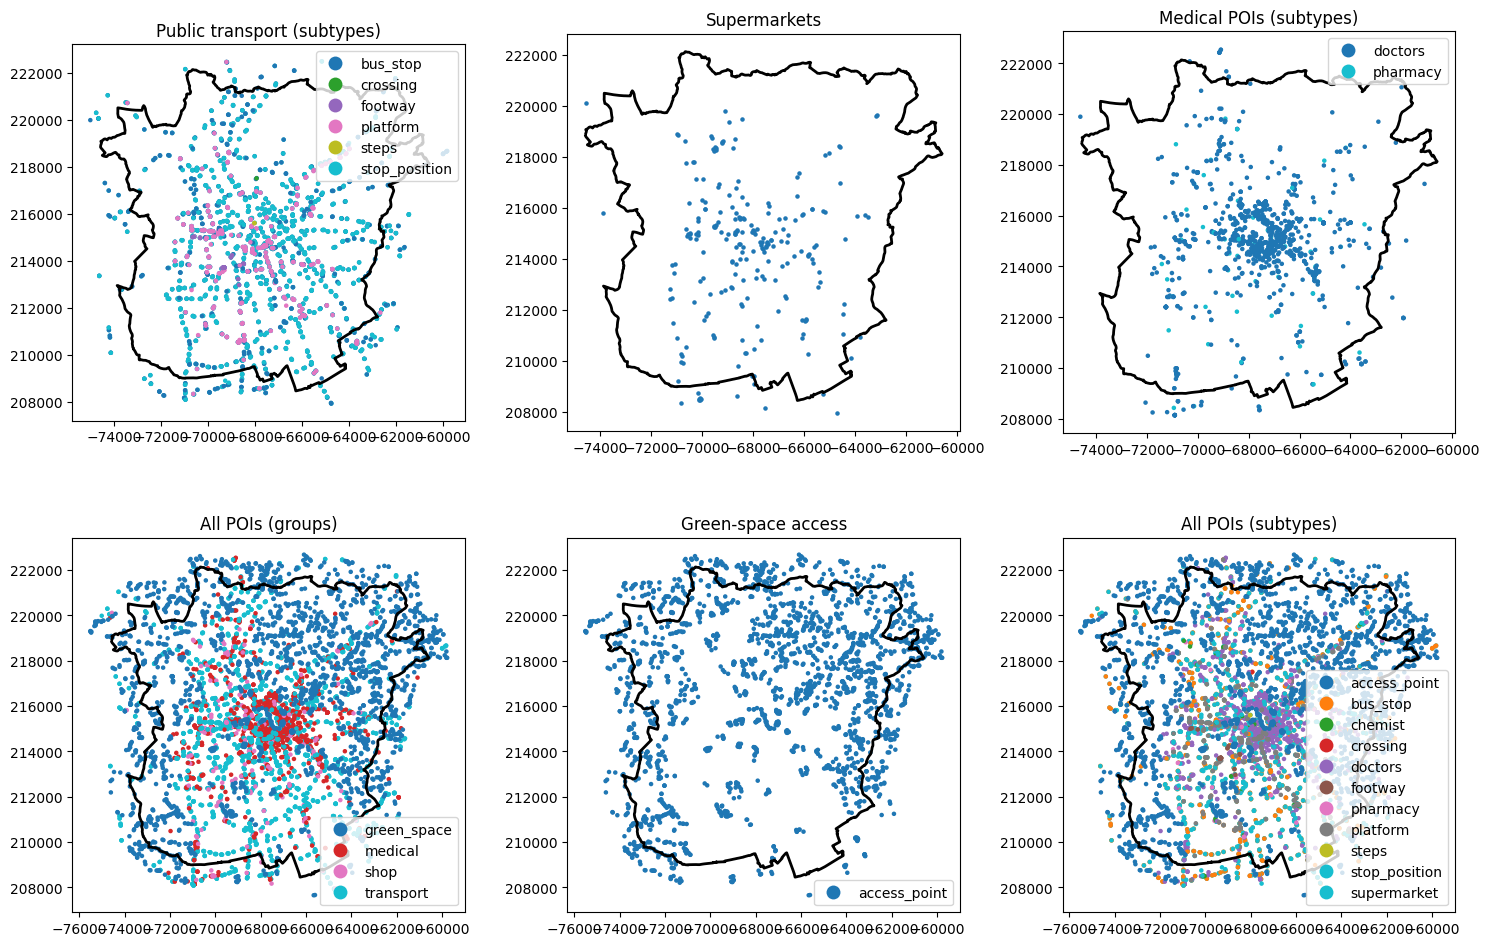

In [25]:
# Plots with poi_group and poi_subtype

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 1) All public transport POIs by subtype (bus_stop, platform, tram_stop, station, halt)
ax1_1 = axs[0, 0]
mask_pt = pois_all_points["poi_group"] == "transport"
pois_all_points[mask_pt].plot(
    ax=ax1_1,
    column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax1_1, edgecolor="black", linewidth=2)
ax1_1.set_title("Public transport (subtypes)")

# 2) Shops by subtype (supermarket, chemist)
ax1_2 = axs[0, 1]
mask_shop = pois_all_points["poi_group"] == "shop"
pois_all_points[mask_shop].plot(
    ax=ax1_2,
    #column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax1_2, edgecolor="black", linewidth=2)
ax1_2.set_title("Supermarkets")

# 3) Medical POIs (doctors, hospital, clinic, pharmacy)
ax1_3 = axs[0, 2]
mask_med = pois_all_points["poi_group"] == "medical"
pois_all_points[mask_med].plot(
    ax=ax1_3,
    column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax1_3, edgecolor="black", linewidth=2)
ax1_3.set_title("Medical POIs (subtypes)")

# 4) All POIs by analysis group (transport / shop / doctor / pharmacy / green_space)
ax2_1 = axs[1, 0]
pois_all_points.plot(
    ax=ax2_1,
    column="poi_group",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax2_1, edgecolor="black", linewidth=2)
ax2_1.set_title("All POIs (groups)")

# 5) Green-space access points
ax2_2 = axs[1, 1]
mask_green = pois_all_points["poi_group"] == "green_space"
pois_all_points[mask_green].plot(
    ax=ax2_2,
    column="poi_subtype",   # e.g. 'access_point'
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax2_2, edgecolor="black", linewidth=2)
ax2_2.set_title("Green-space access")

# 6) Optional: all POIs again, but colored by subtype
ax2_3 = axs[1, 2]
pois_all_points.plot(
    ax=ax2_3,
    column="poi_subtype",
    categorical=True,
    legend=True,
    markersize=5,
)
gdf_graz.boundary.plot(ax=ax2_3, edgecolor="black", linewidth=2)
ax2_3.set_title("All POIs (subtypes)")

plt.tight_layout()
plt.savefig(RESULTS_DIR / "pois_by_group_and_subtype.png", dpi=300)
plt.show()


Quick overview: Display number of features

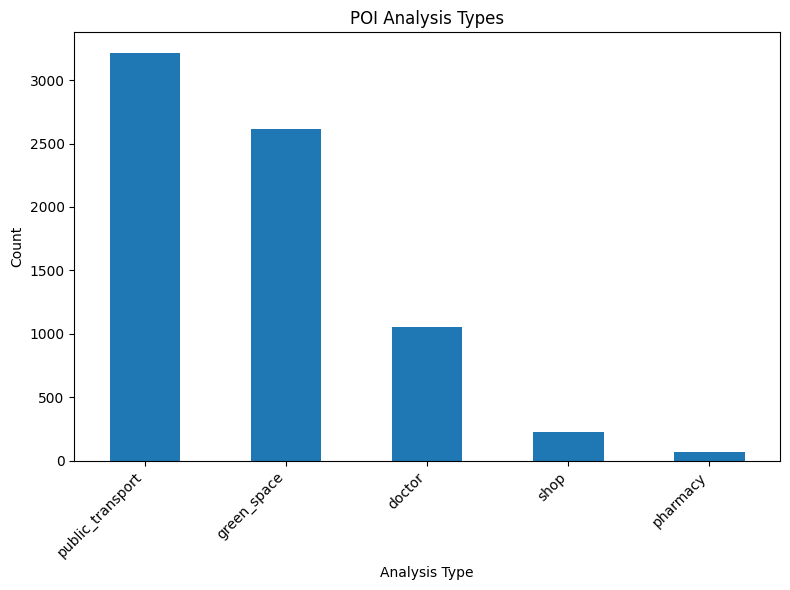

In [26]:
# POI analysis types
analysis_types = pois_all_points["analysis_type"].value_counts(dropna=False)
plt.figure(figsize=(8, 6))
analysis_types.plot(kind='bar')
plt.title("POI Analysis Types")
plt.xlabel("Analysis Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(RESULTS_DIR / "poi_analysis_types.png", dpi=300)
plt.show()

## Network analysis: 15-minute walking distance analysis

For each node in the city network, it should be found which POIs can be reached within 1000m walking distance. 1000m is considered as a 15-minute walk (with 4 km/h). Nodes with all 5 POI types within 1000m walking distance are considered to be in a served area, nodes with less than 5 POI types accessible are in an underserved area.

#### Only keep POIs with nearest node & create lookup

In [27]:
# Only keep POIs that have a nearest_node
pois_routable = pois_all_points[pois_all_points["nearest_node"].notna()].copy()

# group by node and subtype
poi_by_node_and_type = (
    pois_routable.groupby(["nearest_node", "analysis_type"])
    .size()
    .rename("poi_count")
    .reset_index()
)
print(poi_by_node_and_type.head())

# Create easier lookup
node_to_types = defaultdict(set)
for row in poi_by_node_and_type.itertuples(index=False):
    node_to_types[row.nearest_node].add(row.analysis_type)

   nearest_node     analysis_type  poi_count
0      20832703  public_transport          1
1      20832756  public_transport          1
2      20832762  public_transport          2
3      20832809  public_transport          3
4      20832941            doctor          1


##### Routing

For the routing, a single-source Dijkstra's algorithm is used with a cutoff distance of 1000m to find the reachable POI types.

In [28]:
MAX_DIST = 1000  # maximum walking distance in meters


# Routing with Dijkstra's algorithm

print(f"Calculating accessibility from {len(node_to_types)} POI nodes...")

node_coverage = defaultdict(set)  # node_id -> set of reachable analysis_type within 1km

for poi_node, poi_types in node_to_types.items():
    try:
        # Calculate distances from this POI node to all reachable nodes
        lengths = nx.single_source_dijkstra_path_length(
            network_graz,
            source=poi_node,
            weight="length",
            cutoff=MAX_DIST,
        )
        
        # For each reachable node, add all POI types available at this POI node
        for reachable_node in lengths.keys():
            node_coverage[reachable_node] |= poi_types
            
    except nx.NodeNotFound:
        print(f"Warning: POI node {poi_node} not found in network")
        continue

# Convert defaultdict to regular dict for compatibility with your existing code
node_coverage = dict(node_coverage)

print(f"Calculated accessibility for {len(node_coverage)} network nodes")

Calculating accessibility from 4413 POI nodes...
Calculated accessibility for 47304 network nodes


##### Find reachable POI types within 1km

In [29]:
# Use nodes from network graph for saving the analysis
nodes_analysis, edges_analysis = ox.graph_to_gdfs(network_graz, nodes=True, edges=True)

In [30]:
# Find reachable types
nodes_analysis["reachable_types"] = nodes_analysis.index.map(
    lambda n: node_coverage.get(n, set())
)

In [31]:
# Assign POI types required within 1km here
required_types = {
    "shop",
    "public_transport",
    "green_space",
    "pharmacy",
    "doctor"
}

# Column indicating for each node if all required types are reachable within 1 km (Boolean)
nodes_analysis["has_all_required"] = nodes_analysis["reachable_types"].apply(
    lambda s: required_types.issubset(s)
)


##### Clip to residential areas for scenario analysis

In [32]:
# New df with only nodes within residential areas
nodes_analysis_residential = gpd.clip(nodes_analysis, gdf_residential).copy()

## Results of network analysis

##### Visualize nodes by whether they have all 5 POI types accessible

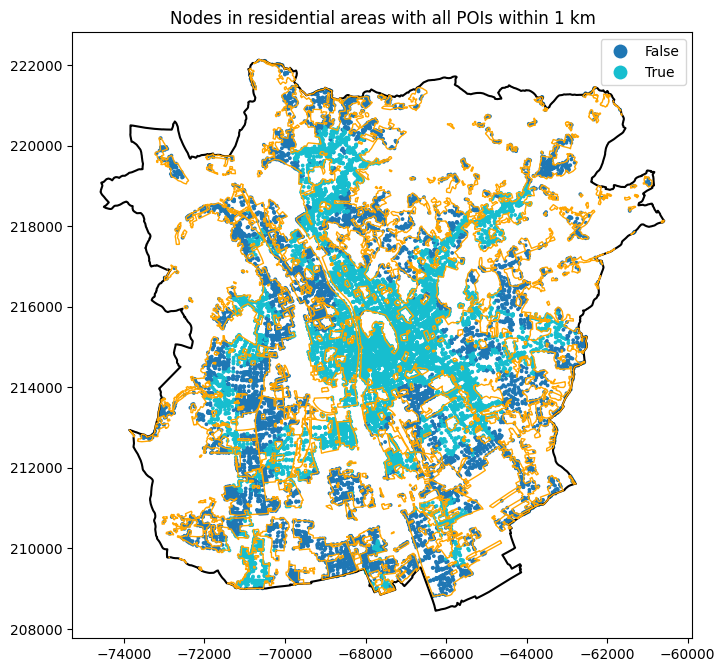

In [33]:
# Plot nodes in residential areas by whether they have all required POI types within 1 km

ax = gdf_graz.boundary.plot(edgecolor="black", figsize=(8, 8))
# plot gdf_residential boundary
gdf_residential.boundary.plot(ax=ax, edgecolor="orange", linewidth=1)

nodes_analysis_residential.plot(
    ax=ax,
    column="has_all_required",
    categorical=True,
    legend=True,
    markersize=3,
)

ax.set_title("Nodes in residential areas with all POIs within 1 km")
plt.savefig(RESULTS_DIR / "residential_nodes_with_all_pois.png", dpi=300)

##### Visualize served and underserved areas

In [34]:
# Prepare extent and grid
minx, miny, maxx, maxy = gdf_graz.total_bounds

resolution = 50  # grid cell resolution in meters; lower values have longer computation time
x_coords = np.arange(minx, maxx, resolution)
y_coords = np.arange(miny, maxy, resolution)
xx, yy = np.meshgrid(x_coords, y_coords)

# Prepare node points and boolean values
# nodes: GeoDataFrame of network nodes with column 'has_all_required'
node_points = np.array([[p.x, p.y] for p in nodes.geometry])
node_access = nodes_analysis["has_all_required"].astype(float).values  # True->1.0, False->0.0

# Interpolate boolean (via nearest neighbour) onto grid
print("Interpolating has_all_required across grid using nearest neighbor...")
grid_access_float = griddata(
    node_points,
    node_access,
    (xx, yy),
    method="nearest"
)

# Convert back to boolean (NaN -> False)
grid_access_bool = ~np.isnan(grid_access_float) & (grid_access_float >= 0.5)

# Create grid polygons within Graz, attach boolean
print("Creating grid cells...")
grid_polygons = []

graz_geom = gdf_graz.geometry.iloc[0]

for i in range(len(x_coords) - 1):
    for j in range(len(y_coords) - 1):
        cell = Polygon([
            (x_coords[i],   y_coords[j]),
            (x_coords[i+1], y_coords[j]),
            (x_coords[i+1], y_coords[j+1]),
            (x_coords[i],   y_coords[j+1]),
        ])

        if not graz_geom.intersects(cell):
            continue

        clipped_cell = cell.intersection(graz_geom)
        if clipped_cell.is_empty or clipped_cell.area < 1:
            continue

        served = bool(grid_access_bool[j, i])

        grid_polygons.append({
            "served": served,            # True = within 15 min of all required services
            "geometry": clipped_cell
        })

grid_gdf = gpd.GeoDataFrame(grid_polygons, crs=nodes.crs)
print(f"Created {len(grid_gdf)} grid cells within Graz")

# Area statistics
grid_gdf["area_m2"] = grid_gdf.geometry.area
area_served = grid_gdf.loc[grid_gdf["served"], "area_m2"].sum()
area_total  = grid_gdf["area_m2"].sum()
share_area  = area_served / area_total
print("Share of area within 15 min of all services:", share_area)


Interpolating has_all_required across grid using nearest neighbor...
Creating grid cells...
Created 51827 grid cells within Graz
Share of area within 15 min of all services: 0.2620519846398321


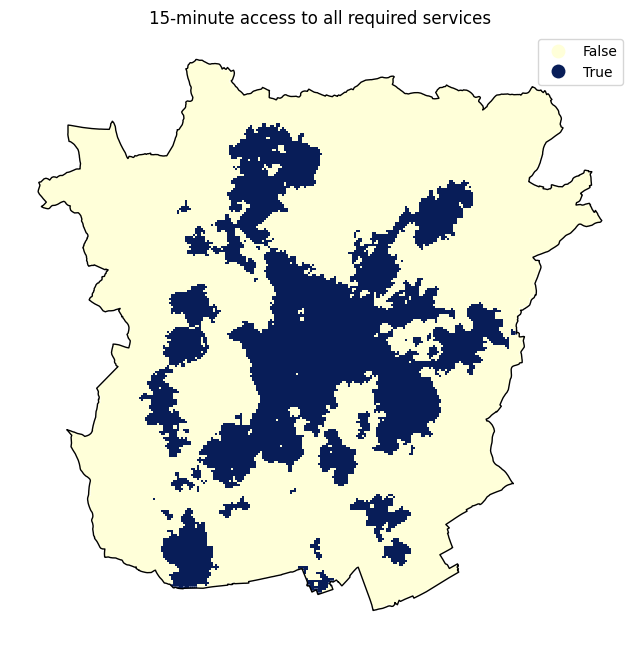

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot grid, colored by served True/False
grid_gdf.plot(
    column="served",
    categorical=True,
    cmap="YlGnBu",       # blue = served, yellow = not
    legend=True,
    ax=ax,
    edgecolor="none"   
)

# Overlay Graz boundary
gdf_graz.boundary.plot(ax=ax, color="black", linewidth=1)

ax.set_title("15-minute access to all required services")
ax.set_axis_off()
plt.show()


## Analysis: Population and area within the 15-minute-city

In [36]:
def pop_disaggregation(pop_grid, reachable_area):
    """
    This function takes raster data containing population data and overlays polygon data to which the population data should be disaggregated to.
    :param pop_grid: raster containing population data
    :param reachable_area: area within the criteria of a 15-minute-city
    """
    with rasterio.open(pop_grid) as src:
        data = src.read(1)
        transform = src.transform
        nodata = src.nodata
        masked = np.ma.masked_equal(data, nodata)
        crs = src.crs
        total_population = masked.sum()
    
    if reachable_area.crs != crs:
        reachable_area = reachable_area.to_crs(crs)
    
    union_geom = reachable_area.loc[reachable_area["served"]].geometry.union_all()

    rows, cols = data.shape
    cell_area = abs(transform.a * transform.e)

    pop_within = 0.0
    
    for row in range(rows):
        for col in range(cols):
            value = data[row, col]
            if value == nodata or np.isnan(value):
                continue
            x1, y1 = rasterio.transform.xy(transform, row, col, offset="ul")
            x2, y2 = rasterio.transform.xy(transform, row, col, offset="lr")
            cell = box(x1, y2, x2, y1)
            if not cell.intersects(union_geom):
                continue
            clipped = cell.intersection(union_geom)
            if clipped.is_empty:
                continue
            weight = clipped.area / cell_area
            pop_within += value * weight

    pop_within_share = pop_within / total_population
    
    return round(pop_within), pop_within_share

In [37]:
pop_graz_15min_city, share_pop_15min_city = pop_disaggregation(POP_GRAZ_PATH, grid_gdf)
print(pop_graz_15min_city)
print(share_pop_15min_city)

162230
0.530251179744177


## Scenario: Add facility to areas with 4 of 5 POIs covered

Now we have found where the 15-minute-city is already implemented. The scenario analysis shows where it can be expanded by adding facilities to areas that are missing only 1 of the 5 POIs.

##### Find nodes with 4 of 5 POIs accessible

In [38]:
# Add per-category coverage boolean columns
nodes_analysis_residential["covered_shop"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: "shop" in s
)
nodes_analysis_residential["covered_public_transport"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: "public_transport" in s
)
nodes_analysis_residential["covered_green_space"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: "green_space" in s
)
nodes_analysis_residential["covered_doctor"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: "doctor" in s
)
nodes_analysis_residential["covered_pharmacy"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: "pharmacy" in s
)

# number of covered categories
nodes_analysis_residential["num_covered"] = (
    nodes_analysis_residential["covered_shop"].astype(int)
    + nodes_analysis_residential["covered_public_transport"].astype(int)
    + nodes_analysis_residential["covered_green_space"].astype(int)
    + nodes_analysis_residential["covered_doctor"].astype(int)
    + nodes_analysis_residential["covered_pharmacy"].astype(int)
)

# consistency with has_all_required
# nodes_analysis["has_all_required"] = nodes_analysis["num_covered"].eq(5)


In [39]:
# Save nodes with exactly 4 of 5 covered
nodes_analysis_residential = nodes_analysis_residential[nodes_analysis_residential["num_covered"] == 4].copy()
nodes_analysis_residential["missing_type"] = nodes_analysis_residential["reachable_types"].apply(
    lambda s: list(required_types - s)[0]
)

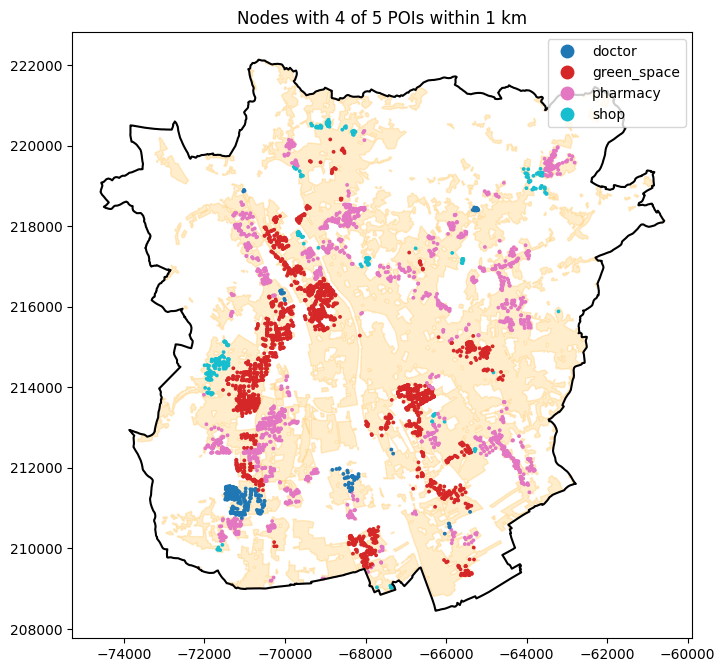

In [40]:
ax = gdf_graz.boundary.plot(edgecolor="black", figsize=(8, 8))
gdf_residential.plot(
    ax=ax, 
    facecolor="orange", 
    edgecolor="orange", 
    alpha=0.2,  # Transparency (0=fully transparent, 1=fully opaque)
    linewidth=1
)
nodes_analysis_residential.plot(
    ax=ax,
    column="missing_type",
    categorical=True,
    legend=True,
    markersize=3,
)

ax.set_title("Nodes with 4 of 5 POIs within 1 km")

plt.savefig(RESULTS_DIR / "residential_nodes_with_4_of_5_pois.png", dpi=300)
plt.show()


##### Cluster nodes with one missing POI with DBSCAN

The nodes with 4 out of 5 POI types accessible are clustered to get areas with one missing facility.

In [41]:
# Split nodes by missing type

types = nodes_analysis_residential["missing_type"].unique()

clusters_per_type = {}
for t in types:
    subset = nodes_analysis_residential[nodes_analysis_residential["missing_type"] == t].copy()
    clusters_per_type[t] = subset

In [ ]:
# Spatial clustering with DBSCAN

eps = 400  # radius of the neighborhood in meters
min_samples = 50  # minimum nr. of nodes to form a cluster, adjust this for different results!

for t, g in clusters_per_type.items():
    coords = np.vstack([g.geometry.x.values, g.geometry.y.values]).T  # Create coordinate stack for DBSCAN

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(coords)   # -1 = noise

    clusters_per_type[t]["cluster_id"] = labels  # which local cluster each node belongs to

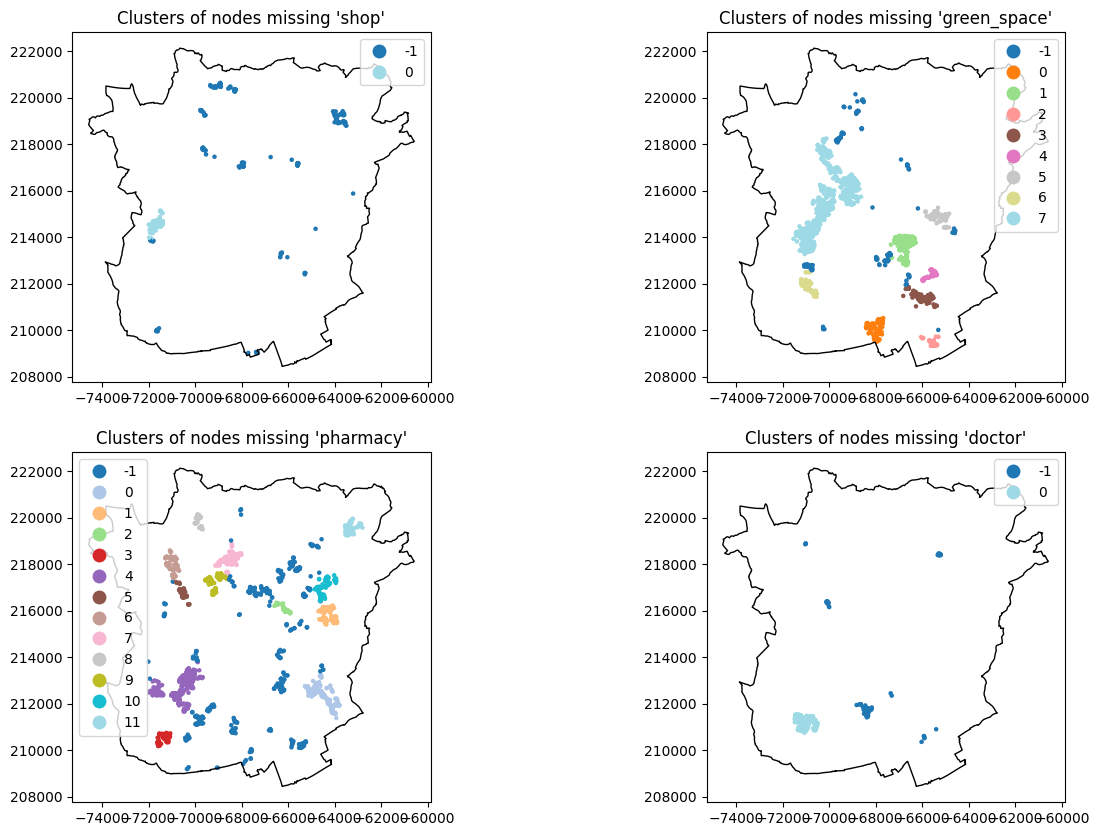

In [43]:
# Plot clusters for each missing type
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, (t, g) in enumerate(clusters_per_type.items()):
    ax = axs[i // 2, i % 2]
    gdf_graz.boundary.plot(ax=ax, edgecolor="black", linewidth=1)

    g.plot(
        ax=ax,
        column="cluster_id",
        categorical=True,
        legend=True,
        markersize=5,
        cmap="tab20"
    )

    ax.set_title(f"Clusters of nodes missing '{t}'")

plt.savefig(RESULTS_DIR / "clusters_missing_poi_types.png", dpi=300)
plt.show()

##### Find sites for the new facility

Facilities are added to the nearest nodes of the centroids of the clusters missing one facility.

In [44]:
candidate_sites = []

for t, g in clusters_per_type.items():
    for cid, group in g[g["cluster_id"] != -1].groupby("cluster_id"):
        # centroid of cluster
        cx = group.geometry.x.mean()
        cy = group.geometry.y.mean()

        # choose node closest to centroid as candidate facility
        d2 = (group.geometry.x - cx)**2 + (group.geometry.y - cy)**2
        medoid_node = group.loc[d2.idxmin()]

        candidate_sites.append({
            "missing_type": t,
            "cluster_id": cid,
            "node_id": medoid_node.name,
            "geometry": medoid_node.geometry,
        })

candidates_gdf = gpd.GeoDataFrame(candidate_sites, crs=project_crs)

<Axes: >

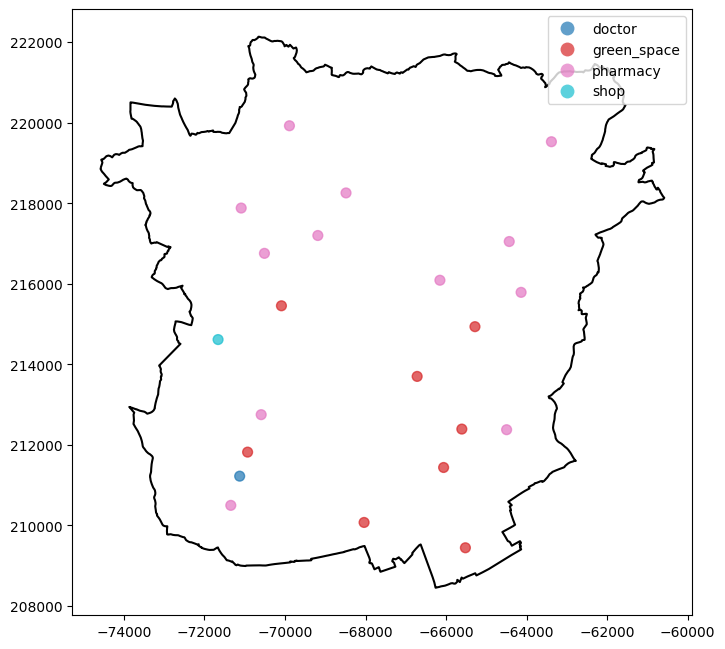

In [45]:
# Plot candidate sites
fig, ax = plt.subplots(figsize=(8, 8))
gdf_graz.boundary.plot(ax=ax, edgecolor="black")
candidates_gdf.plot(
    ax=ax,
    column="missing_type",
    categorical=True,
    legend=True,
    markersize=50,
    alpha=0.7,
)

##### Add facilities to areas with 4 of 5 POIs covered (Virtual Injection)

In [46]:
# Copy
node_to_types_scenario = copy.deepcopy(node_to_types)

# Loop through our proposed candidate sites (the new facilities)
# Add them to the dictionary that tells us which node has which POI
for index, row in candidates_gdf.iterrows():
    node_id = row["node_id"]
    new_type = row["missing_type"]
    
    # Check if the node is already in our dictionary
    if node_id in node_to_types_scenario:
        # Add the new type to the existing set
        node_to_types_scenario[node_id].add(new_type)
    else:
        # Create a new entry for this node
        node_to_types_scenario[node_id] = {new_type}

print(f"Added {len(candidates_gdf)} new facilities.")

Added 22 new facilities.


##### Recalculate network analysis with the new, added facilities

Accessibility is recalculated to find how the situation improves through adding the proposed facilities.

In [47]:
# Recalculation of accessibility for scenario

print(f"Calculating scenario accessibility from {len(node_to_types_scenario)} POI nodes...")

node_coverage_scenario = defaultdict(set)

for poi_node, poi_types in node_to_types_scenario.items():
    try:
        lengths = nx.single_source_dijkstra_path_length(
            network_graz,
            source=poi_node,
            weight="length",
            cutoff=MAX_DIST,
        )
        
        for reachable_node in lengths.keys():
            node_coverage_scenario[reachable_node] |= poi_types
            
    except nx.NodeNotFound:
        print(f"Warning: POI node {poi_node} not found in network")
        continue

node_coverage_scenario = dict(node_coverage_scenario)

# Add the new results to our nodes DataFrame
nodes_analysis["reachable_types_scenario"] = nodes_analysis.index.map(
    lambda n: node_coverage_scenario.get(n, set())
)

# Check if all 5 required types are present now
nodes_analysis["has_all_required_scenario"] = nodes_analysis["reachable_types_scenario"].apply(
    lambda s: required_types.issubset(s)
)

Calculating scenario accessibility from 4433 POI nodes...


In [48]:
# Define status for comparison

# 0 = Still unserved (Bad)
# 1 = Baseline (Was already good before)
# 2 = New Served (Improvement due to our scenario)

def get_status_code(row):
    if row["has_all_required"] == True:
        return 1
    elif row["has_all_required_scenario"] == True:
        return 2
    else:
        return 0

# Apply this function to every row
nodes_analysis["scenario_status"] = nodes_analysis.apply(get_status_code, axis=1)

# Show a quick count of how many nodes are in which category
print("Nodes status breakdown:")
# Rename the codes to text for better readability in the print output
print(nodes_analysis["scenario_status"].value_counts().rename({0: "Unserved", 1: "Baseline", 2: "New Served"}))

Nodes status breakdown:
scenario_status
Baseline      23049
Unserved      19959
New Served     4497
Name: count, dtype: int64


##### Fix spatial bias

In [49]:
# Consistent Interpolation to fix spatial bias (first result had slight deviation between baseline and scenario grids)

# we get the target coordinates ONCE
# We use the center points (centroids) of the grid cells
grid_x = grid_gdf.geometry.centroid.x
grid_y = grid_gdf.geometry.centroid.y
grid_centroids = np.column_stack((grid_x, grid_y))

# 2. Interpolate BOTH states onto these exact coordinates
# This guarantees that there is no shift between "Before" and "After" layers

# Re-calculate Baseline (Current State)
values_baseline = nodes_analysis["has_all_required"].astype(float)

grid_values_baseline = griddata(
    points=node_points,       # Source: Street nodes
    values=values_baseline,   # Source: Baseline True/False
    xi=grid_centroids,        # Target: Grid centers
    method="nearest"
)

# Calculate Scenario (Future State)
values_scenario = nodes_analysis["has_all_required_scenario"].astype(float)

grid_values_scenario = griddata(
    points=node_points,       # Source: Street nodes
    values=values_scenario,   # Source: Scenario True/False
    xi=grid_centroids,        # Target: Grid centers
    method="nearest"
)

# Save clean boolean values to the grid
# We use 0.5 as the threshold (nearest neighbor gives 0.0 or 1.0)
grid_gdf["served_baseline_clean"] = (grid_values_baseline >= 0.5)
grid_gdf["served_scenario_clean"] = (grid_values_scenario >= 0.5)

# Calculate the Map Status (0, 1, 2)
# Now we compare the two CLEAN columns. The artifacts should be gone.
grid_gdf["status_plot"] = 0  # Default: Unserved

# Baseline: Was already served
grid_gdf.loc[grid_gdf["served_baseline_clean"] == True, "status_plot"] = 1

# New Served: Was NOT served before, but IS served now
mask_newly_served = (grid_gdf["served_baseline_clean"] == False) & (grid_gdf["served_scenario_clean"] == True)
grid_gdf.loc[mask_newly_served, "status_plot"] = 2

print("Interpolation finished. Spatial bias should be removed.")


Interpolation finished. Spatial bias should be removed.


## Results of the scenario analysis

##### Population and area statistics with the added facilities

In [50]:
# Population and Area Statistics (Delta Analysis)

# Calculate Baseline Population
# FIX: We select ONLY geometry and the clean baseline column to avoid duplicates
grid_temp_base = grid_gdf[["geometry", "served_baseline_clean"]].copy()
grid_temp_base = grid_temp_base.rename(columns={"served_baseline_clean": "served"})

# Run the population function for Baseline
pop_baseline, share_baseline = pop_disaggregation(POP_GRAZ_PATH, grid_temp_base)

# Calculate Scenario Population
# FIX: We select ONLY geometry and the clean scenario column
grid_temp_scen = grid_gdf[["geometry", "served_scenario_clean"]].copy()
grid_temp_scen = grid_temp_scen.rename(columns={"served_scenario_clean": "served"})

# Run the population function for Scenario
pop_scenario, share_scenario = pop_disaggregation(POP_GRAZ_PATH, grid_temp_scen)

# Calculate the Difference
pop_diff = pop_scenario - pop_baseline

print(f"--- RESULTS (Bias Corrected) ---")
print(f"Population served (Baseline): {pop_baseline:,.0f} ({share_baseline:.2%})")
print(f"Population served (Scenario): {pop_scenario:,.0f} ({share_scenario:.2%})")
print(f"IMPACT: +{pop_diff:,.0f} people gained access!")

--- RESULTS (Bias Corrected) ---
Population served (Baseline): 162,600 (53.15%)
Population served (Scenario): 197,466 (64.54%)
IMPACT: +34,866 people gained access!


##### Visualizations of the new situation with the added facilities

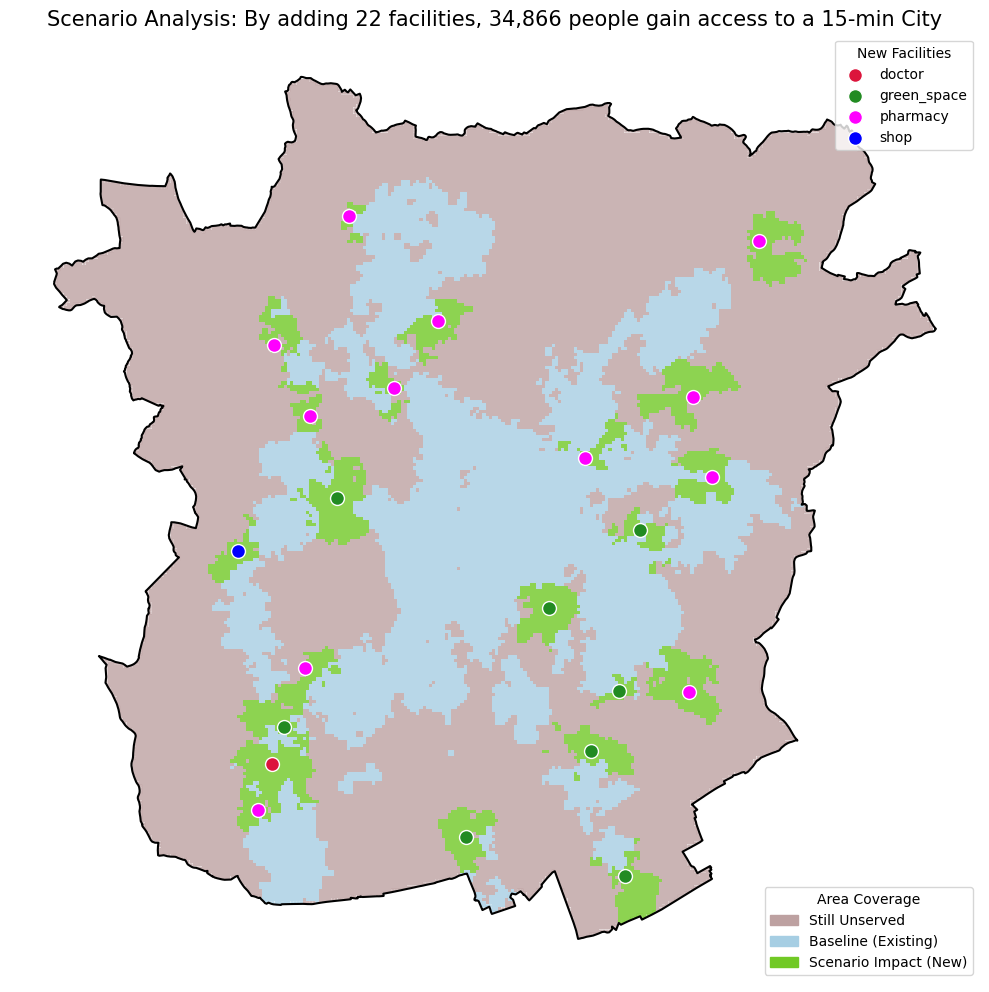

In [51]:
# Final Visualization: Comparison Map with Custom Colors
fig, ax = plt.subplots(figsize=(10, 10))

# Background Grid (Area Status)
grid_colors = ["#bda1a1", '#a6cee3', "#71c925"] 
cmap_grid = ListedColormap(grid_colors)

grid_gdf.plot(
    column="status_plot",
    cmap=cmap_grid,
    ax=ax,
    edgecolor="none",
    alpha=0.8
)

# City Boundary

gdf_graz.boundary.plot(ax=ax, color="black", linewidth=1.5, zorder=5)

# New Facilities (Candidates) with Custom Colors

type_colors = {
    "green_space": "forestgreen",
    "shop": "blue",
    "doctor": "crimson",
    "pharmacy": "magenta",
    "public_transport": "orange"
}


for m_type, data_subset in candidates_gdf.groupby("missing_type"):
    
    my_color = type_colors.get(m_type, "black")
    
    data_subset.plot(
        ax=ax,
        color=my_color,
        markersize=100,
        edgecolor="white",
        linewidth=1,
        zorder=10,
        label=m_type
    )

# LEGEND 1: Facilities
first_legend = ax.legend(loc='upper right', title="New Facilities")
ax.add_artist(first_legend) # IMPORTANT: Add it back, because the next legend would overwrite it

# LEGEND 2: Area Status
patch_grey  = mpatches.Patch(color='#bda1a1', label='Still Unserved')
patch_blue  = mpatches.Patch(color='#a6cee3', label='Baseline (Existing)')
patch_green = mpatches.Patch(color="#71c925", label='Scenario Impact (New)')
ax.legend(handles=[patch_grey, patch_blue, patch_green], loc='lower right', title="Area Coverage")
plt.title(f"Scenario Analysis: By adding {len(candidates_gdf)} facilities, {pop_diff:,.0f} people gain access to a 15-min City", fontsize=15)
ax.set_axis_off()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "scenario_analysis_map.png", dpi=300)
plt.show()
